In [1]:
import numpy as np
from Simulation.Motion import State, GPS, Drive
from matplotlib import pyplot as plt

bot_spec = {'wheelbase': 0.235,
            'wheel_velocity_range': [-0.5,0.5], # m/s, [min max]
            'min_wheel_speed': 0.0,
            'wheel_diameter': 0.072,
            'body_radius': 0.175,
            'wheelbase_offset': 0.0,
            'wheel_velocity_var': 0.0,
            'steering_var': 0.0,
            'abs_min_turning_radius': 0.0}
%matplotlib inline

In [2]:
state = State(pose=[0.0,0.0,0.0], kinematic = [0.1, 0.0], dt = 0.5)

In [3]:
state.reset()

In [4]:
state.reset()
sim_len = 500
poses = np.zeros((sim_len,3))
Rs = np.zeros(sim_len)
ICCs = np.zeros((sim_len,2))
kinematics = np.zeros((sim_len,2))
for i in range(sim_len):
    kinematics[i] = np.array(state.kinematic)
    Rs[i] = state.turning_radius()
    ICCs[i] = np.array(state.ICC())
    state.update_pose()
    poses[i] = state.pose
    if i>91 and i<110:
        state.update_kinematic(new_w = np.pi/18)
    elif i>182 and i<219:
        state.update_kinematic(new_w = np.pi/36)
    elif i>300 and i<310:
        state.update_kinematic(new_w = np.pi/9)
    elif i>400 and i<418:
        state.update_kinematic(new_w = np.pi/17)
    else:
        state.update_kinematic(new_w = 0.0)
        

In [5]:
gps = GPS(pose = state.pose)

In [6]:
drive = Drive(custom=True, custom_spec=bot_spec)

In [7]:
state.reset()
sim_len = len(kinematics)
poses_hat = np.zeros((sim_len,3))
kinematics_hat = np.zeros((sim_len,2))
for i, kine in enumerate(kinematics):
    drive.kinematic_update(kine)
    print(kine)
    print(drive.kinematic)
    state.update_kinematic(drive.kinematic)
    state.update_pose()
    poses_hat[i]=state.pose
    kinematics_hat[i]=state.kinematic
    

[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05652286]
[0.1 0. ]
[ 0.09934242 -0.05

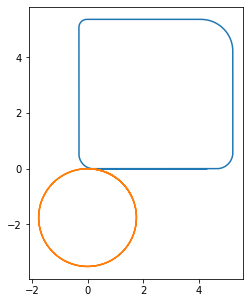

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(poses[:,0], poses[:,1])
ax.plot(poses_hat[:,0], poses_hat[:,1])
ax.set_aspect('equal')


In [ ]:
fig, ax = plt.subplots(1,2,figsize=(5,5))
ax[0].plot(kinematics[:,0])
ax[0].plot(kinematics_hat[:,0])
ax[1].plot(kinematics[:,1])
ax[1].plot(kinematics_hat[:,1])
